# Import Necessary Packages

In [130]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter


%matplotlib inline


## Imports Datasets from Kaggle

In [131]:
from typing import Optional

from transformers.models.esm.openfold_utils.protein import from_prediction
!pip install kagglehub

## Dataset Loading 
#### Normally datasets are downloaded from the Kaggle, but in the purpose of time-saving the local path placed instead.
#### If you want to download the datasets again, just uncomment the code below.

In [132]:
# path = "/Users/masoud/Downloads/MovieLens_1M_Dataset/orginal_file"

path = kagglehub.dataset_download("odedgolden/movielens-1m-dataset")

# print("Path to dataset files:", path)

## Load MovieLens 1M Dataset (movies.dat, ratings.dat, users.dat)

### In this step, we load the three core files from the MovieLens 1M dataset:
#### - `movies.dat` – contains movie information (ID, title, genres)
#### - `ratings.dat` – contains user ratings for movies
#### - `users.dat` – contains demographic info about users

In [133]:
# Load movies.dat
movies_path = f"{path}/movies.dat"
movie_df = pd.read_csv(movies_path, sep="::", engine="python",
                        names=["MovieID", "Title", "Genres"],
                        encoding="latin-1")

# Load ratings.dat
ratings_path = f"{path}/ratings.dat"
ratings_df = pd.read_csv(ratings_path, sep="::", engine="python",
                         names=["UserID", "MovieID", "Rating", "Timestamp"],
                         encoding="latin-1")

# Load users.dat
users_path = f"{path}/users.dat"
users_df = pd.read_csv(users_path, sep="::", engine="python",
                       names=["UserID", "Gender", "Age", "Occupation", "Zip-code"],
                       encoding="latin-1")

# Display first few rows from each DataFrame
print("Movies:")
print(movie_df.head(), "\n")

print("Ratings:")
print(ratings_df.head(), "\n")

print("Users:")
print(users_df.head())


Movies:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy 

Ratings:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291 

Users:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


### Randomly Sample 10 Rows from `movie_df`


In [134]:
movie_df.sample(10)

,MovieID,Title,Genres
258,261,Little Women (1994),Drama
3251,3320,Mifune (Mifunes sidste sang) (1999),Comedy|Romance
3134,3203,Dead Calm (1989),Thriller
1321,1342,Candyman (1992),Horror
423,427,Boxing Helena (1993),Mystery|Romance|Thriller
1833,1902,Dream for an Insomniac (1996),Drama|Romance
3076,3145,"Cradle Will Rock, The (1999)",Drama
115,117,"Young Poisoner's Handbook, The (1995)",Crime
3661,3730,"Conversation, The (1974)",Drama|Mystery
1079,1095,Glengarry Glen Ross (1992),Drama


### Display DataFrame Info


In [135]:
movie_df.info()
print('------------------------------------------')
ratings_df.info()
print('------------------------------------------')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  --

### Summary Statistics


In [136]:
movie_df.describe()

,MovieID
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [137]:
ratings_df.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [138]:
users_df.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


### Checkout NaN values percent in each column


In [139]:
def check_nan_percent(df):
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

check_nan_percent(movie_df)


,null_percent,total_null


In [140]:
check_nan_percent(users_df)

,null_percent,total_null


In [141]:
check_nan_percent(ratings_df)


,null_percent,total_null


### Check missing values


### Creating an Age Group Feature in `users_df`

To better understand user demographics, we create a new categorical column called `age_group` in the `users_df` DataFrame, based on the existing `Age` column.

The classification is based on the following logic:

| Age Range | Age Group      |
|-----------|----------------|
| 5–12      | Gradeschooler  |
| 13–19     | Teenager       |
| 20–35     | Young          |
| 36–55     | Midlife        |
| 56+       | Old            |

In [142]:
def classify_age(age):
    try:
        age = int(age)
        if 5 <= age <= 12:
            return 'Gradeschooler'
        elif 13 <= age <= 19:
            return 'Teenager'
        elif 20 <= age <= 35:
            return 'Young'
        elif 36 <= age <= 55:
            return 'Midlife'
        else:
            return 'Old'
    except:
        return 'Unknown'

users_df['age_group'] = users_df['Age'].apply(classify_age)


## Common genere of movies


/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/3041620841.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genres), y=list(counts), palette='viridis')


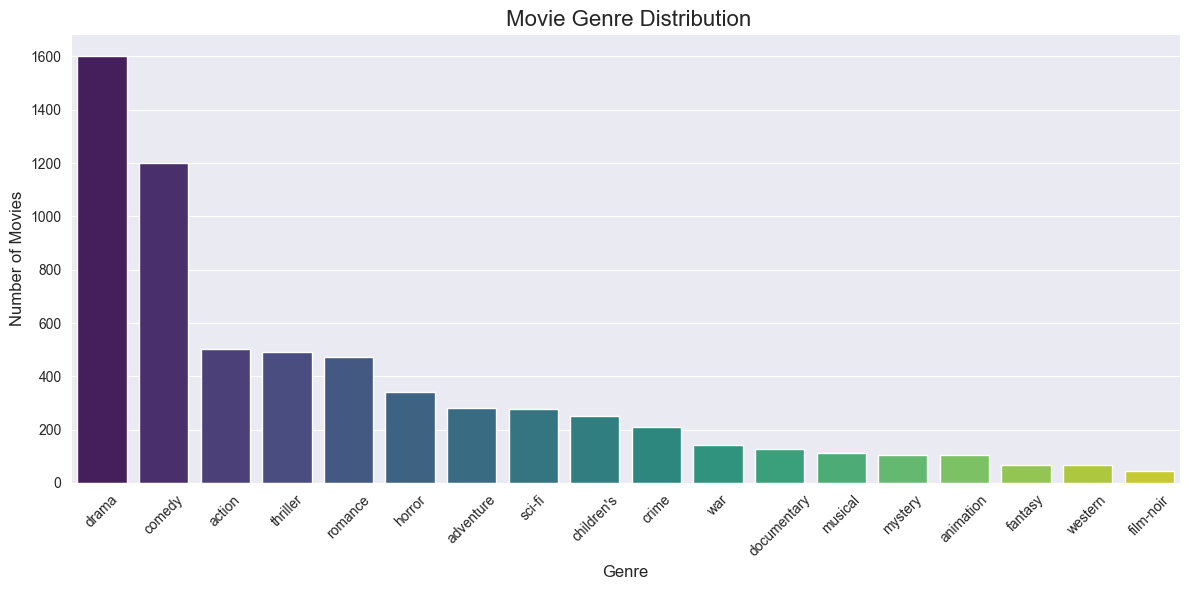

In [143]:
# Split genre strings into lists and flatten them
genre_series = movie_df['Genres'].str.lower().str.split('|')
flat_genres = [genre for sublist in genre_series.dropna() for genre in sublist]

# Count genre frequency
genre_counts = Counter(flat_genres)

# Sort genres by count (descending)
sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
genres, counts = zip(*sorted_genres)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(genres), y=list(counts), palette='viridis')

plt.title(' Movie Genre Distribution', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Drama and comedy are the most common genere type. We must also note that it can not be a clear indication of people's preference, because One movie can have more than one genere and drama is the most commor genere type.

## Yearly Movie Release Trend

### In this section, we visualize the number of movies released each year using data from the `Title` column, which contains the release year in parentheses (e.g., `"Toy Story (1995)"`).

We will:
#### -  Extract the release year using regular expressions
#### -  Count how many movies were released each year
#### -  Create a clean and colorful line chart to show the trend

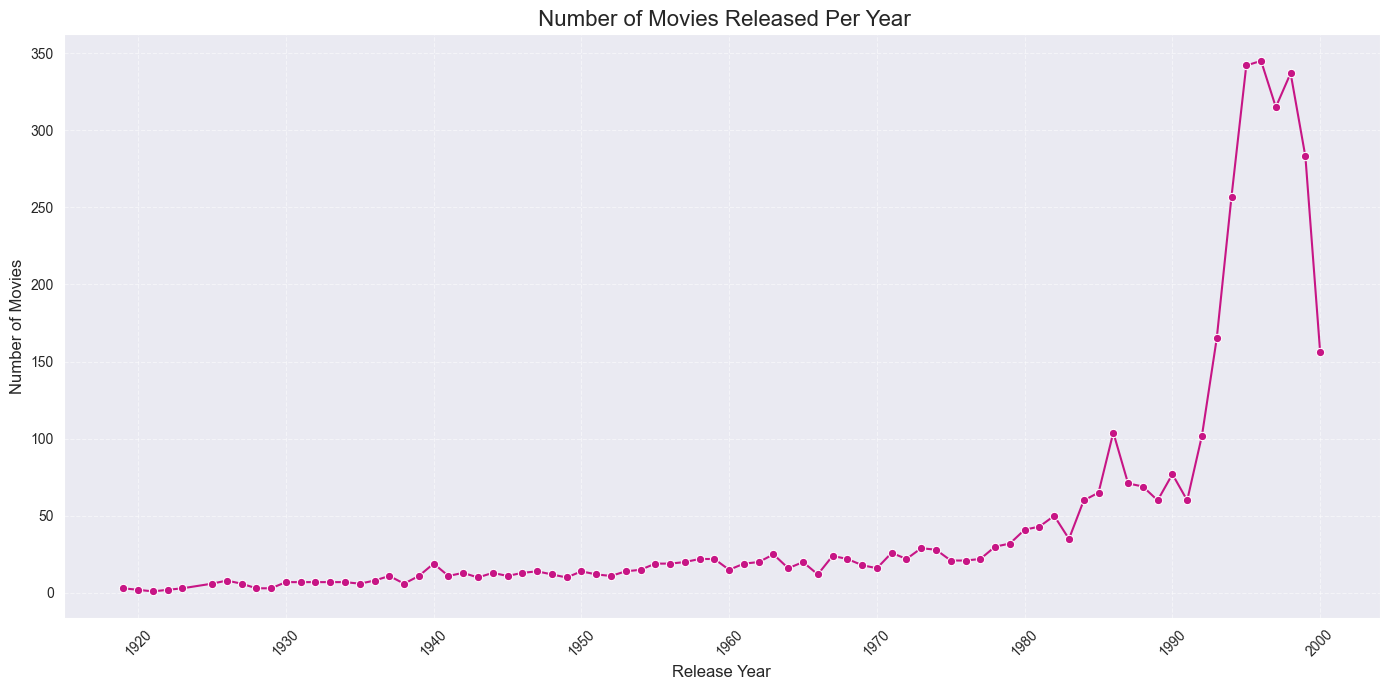

In [144]:
# Step 1: Extract release year from 'Title'
movie_df['release_year'] = movie_df['Title'].str.extract(r'\((\d{4})\)').astype(float)

# Step 2: Count movies per year, sort by year
yearly_release_counts = (
    movie_df
    .dropna(subset=['release_year'])
    .groupby('release_year')
    .size()
    .sort_index()  # sort by year ascending
)

# Step 3: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x=yearly_release_counts.index, y=yearly_release_counts.values, marker='o', color='mediumvioletred')

plt.title(' Number of Movies Released Per Year', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Gender Distribution of Users

#### In this section, we visualize the **gender distribution** of users in the dataset. This helps us understand the male-to-female ratio of users who rated movies.


/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1662472166.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1662472166.py:28: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/simon/PycharmProjects/rec-sys-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


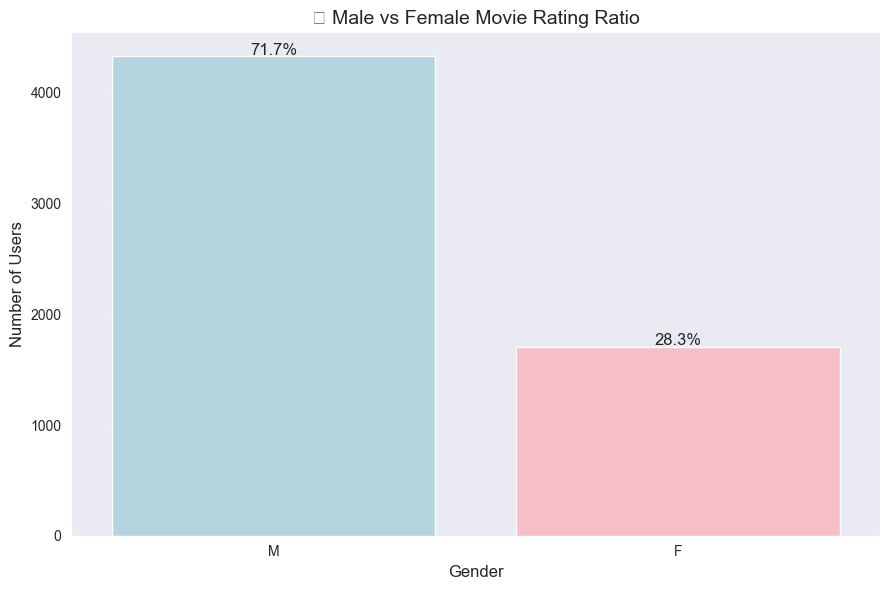

In [145]:
# Step 1: Count users by gender
gender_counts = users_df['Gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Step 2: Plot with custom colors
plt.figure(figsize=(9, 6))

# Define gender-based color palette
gender_palette = {'M': '#ADD8E6',  # Light Blue
                  'F': '#FFB6C1'}  # Light Pink

# Create bar plot
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette=gender_palette
)

# Add percentage labels above bars
for i, (count, pct) in enumerate(zip(gender_counts.values, gender_percentages.values)):
    plt.text(i, count + 10, f"{pct:.1f}%", ha='center', fontsize=12)

# Final plot formatting
plt.title('👥 Male vs Female Movie Rating Ratio', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Movie Watchers by Age Group

### In this section, we visualize how users are distributed across different age groups. This helps us understand which demographics are most active in rating or watching movies.


/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1445606248.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='Set2')


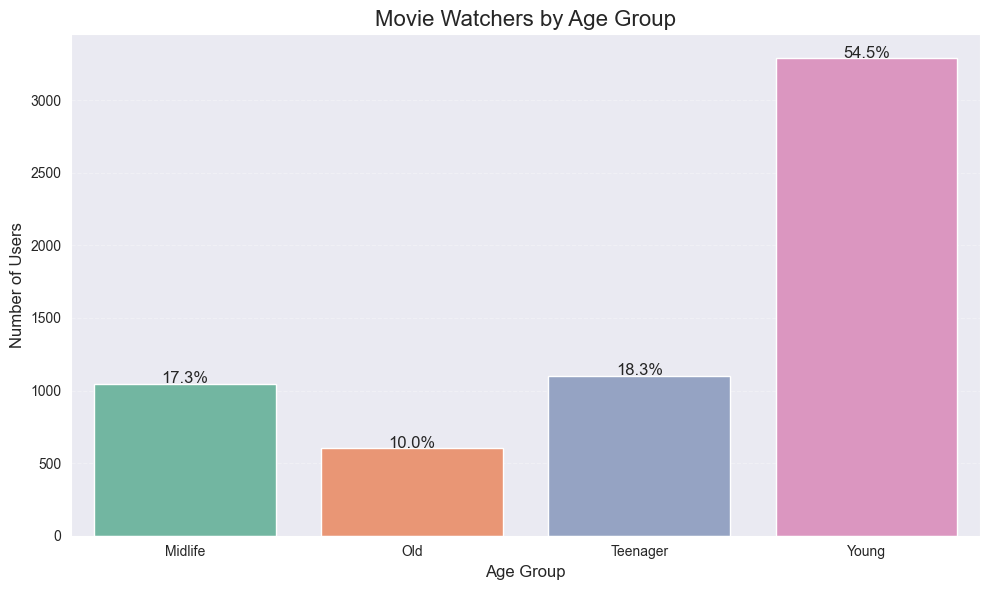

In [146]:
# Step 1: Count users by age group
age_group_counts = users_df['age_group'].value_counts().sort_index()
age_group_percentages = (age_group_counts / age_group_counts.sum()) * 100

# Step 2: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='Set2')

# Step 3: Add percentage labels
for i, (count, pct) in enumerate(zip(age_group_counts.values, age_group_percentages.values)):
    plt.text(i, count + 5, f"{pct:.1f}%", ha='center', fontsize=12)

# Step 4: Final formatting
plt.title('Movie Watchers by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Movie Genre Preferences by Gender
### This part explores how different movie genres are rated by male and female users.



<Figure size 1200x600 with 0 Axes>

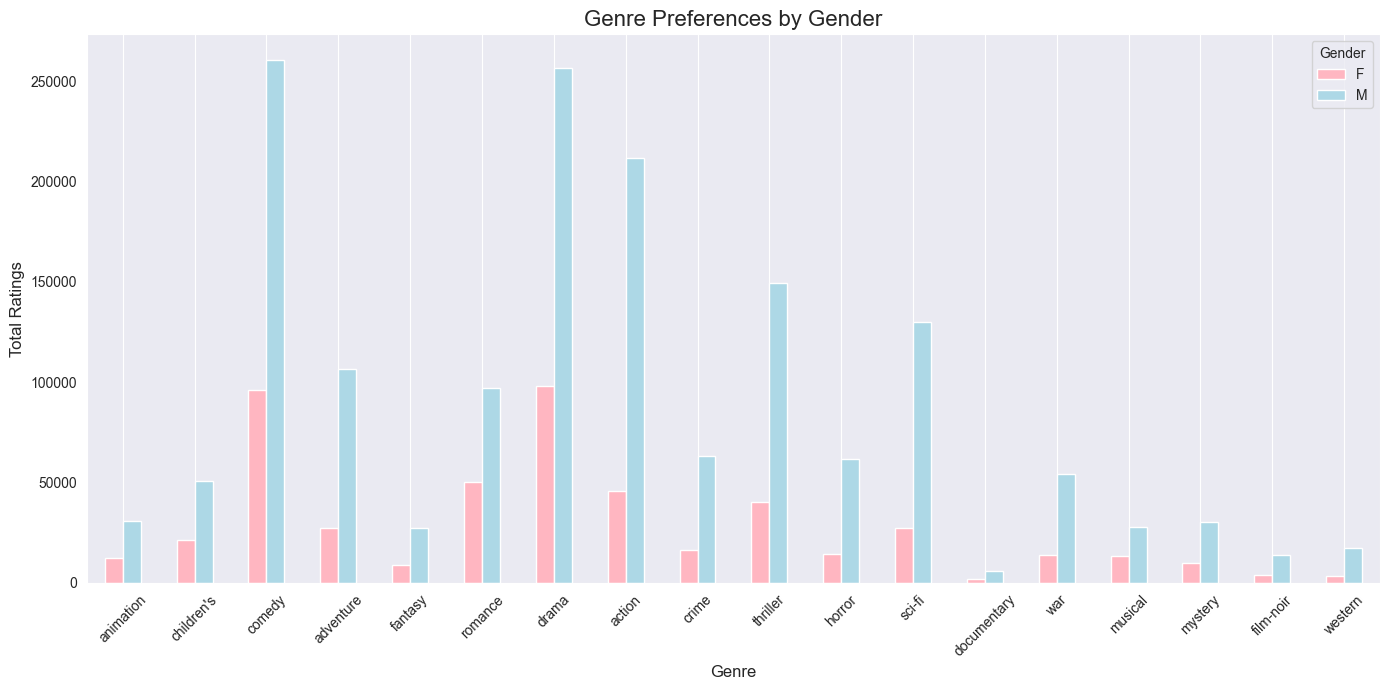

In [147]:
# Step 1: Rename and standardize column names
ratings_df.rename(columns={'UserID': 'user_id', 'MovieID': 'movie_id'}, inplace=True)
users_df.rename(columns={'UserID': 'user_id'}, inplace=True)
movie_df.rename(columns={'MovieID': 'movie_id'}, inplace=True)

# Clean all column names in users_df (lowercase, no spaces)
users_df.columns = users_df.columns.str.lower().str.strip()
movie_df.columns = movie_df.columns.str.lower().str.strip()

# Step 2: Extract and prepare genre list
genre_series = movie_df['genres'].str.lower().str.split('|')
flat_genres = [genre.strip() for sublist in genre_series.dropna() for genre in sublist]
genre_counts = Counter(flat_genres)
genres = list(genre_counts.keys())

# Step 3: One-hot encode genres in movie_df
for genre in genres:
    movie_df[genre] = movie_df['genres'].str.lower().str.contains(genre).astype(int)

# Step 4: Merge all dataframes
rating_user_df = ratings_df.merge(users_df, how='inner', on='user_id')
rating_user_movie_df = rating_user_df.merge(movie_df, how='inner', on='movie_id')

# Step 5: Group by gender and sum genre ratings
temp_df = rating_user_movie_df.groupby('gender')[genres].sum()
temp_df = temp_df.transpose()
temp_df.columns.name = 'Gender'
temp_df.index.name = 'Genre'

# Step 6: Plot genre preferences by gender
plt.figure(figsize=(12, 6))
temp_df.plot(
    kind='bar',
    figsize=(14, 7),
    color=['lightblue' if col == 'M' else 'lightpink' for col in temp_df.columns]
)
plt.title('Genre Preferences by Gender', fontsize=16)
plt.ylabel('Total Ratings', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Gender')
plt.grid(axis='y')
plt.show()



## Movie Ratings Analysis by Gender
### This notebook visualizes how male and female users rate movies using side-by-side bar charts.

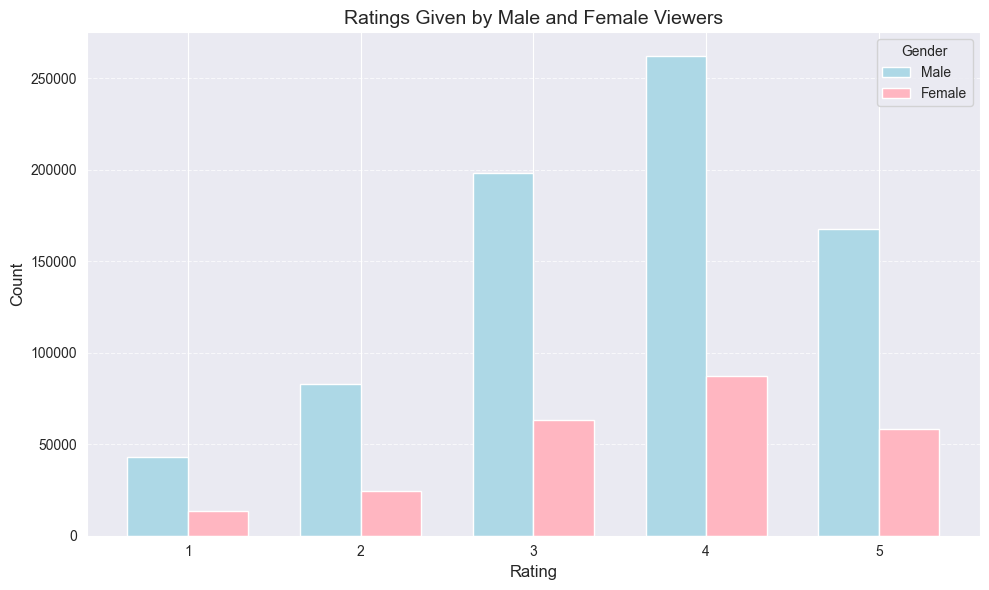

In [148]:
# Step 0: Standardize gender + rating column names
rating_user_df['gender'] = rating_user_df['gender'].str.lower().str.strip()
rating_user_df.rename(columns={'Rating': 'rating'}, inplace=True)

# Step 1: Group and reshape
temp_df = rating_user_df.groupby(['rating', 'gender']).size().unstack(fill_value=0)

# Step 2: Prepare for side-by-side bar plot
ratings = temp_df.index
x = np.arange(len(ratings))
bar_width = 0.35

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, temp_df.get('m', 0), width=bar_width, label='Male', color='lightblue')
plt.bar(x + bar_width/2, temp_df.get('f', 0), width=bar_width, label='Female', color='lightpink')

# Step 4: Customize plot
plt.title('Ratings Given by Male and Female Viewers', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=x, labels=ratings)
plt.legend(title='Gender')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Top 10 Most Watched Movies
### This section analyzes the 10 most-watched (most-rated) movies in the dataset by visualizing them using a horizontal bar chart

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/3312410876.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='viridis')


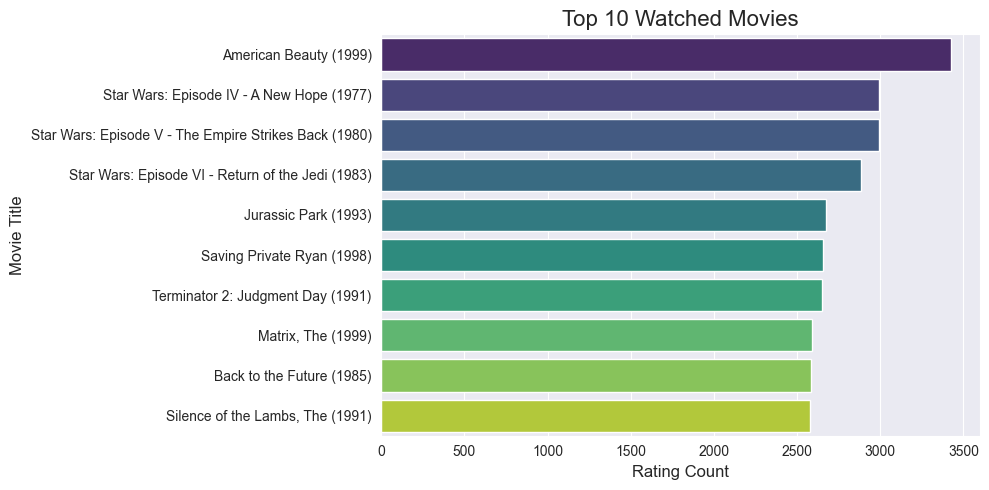

In [149]:
# Function to draw a horizontal bar chart
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(10, 5))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Rating Count', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.tight_layout()
    plt.show()

# Step 1: Get top 10 most-rated movies by movie_id
top_ten_rated_movies = ratings_df.groupby('movie_id').size().sort_values(ascending=False).head(10)

# Step 2: Merge with movie_df to get the actual movie titles
top_movies = top_ten_rated_movies.reset_index().merge(
    movie_df[['movie_id', 'title']], on='movie_id'
)

# Step 3: Plot
draw_horizontal_movie_bar(top_movies['title'], top_movies[0], 'Top 10 Watched Movies')


## Top 10 Most Watched Movies by Gender
### This section explores gender-based movie preferences by identifying the top 10 most-watched movies among male and female users. The results are visualized using horizontal bar charts for easy comparison.

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


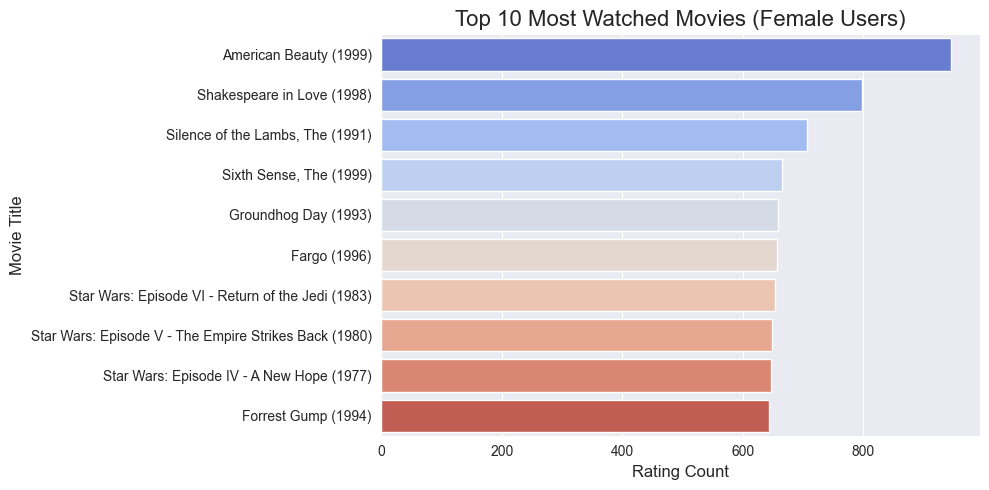

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


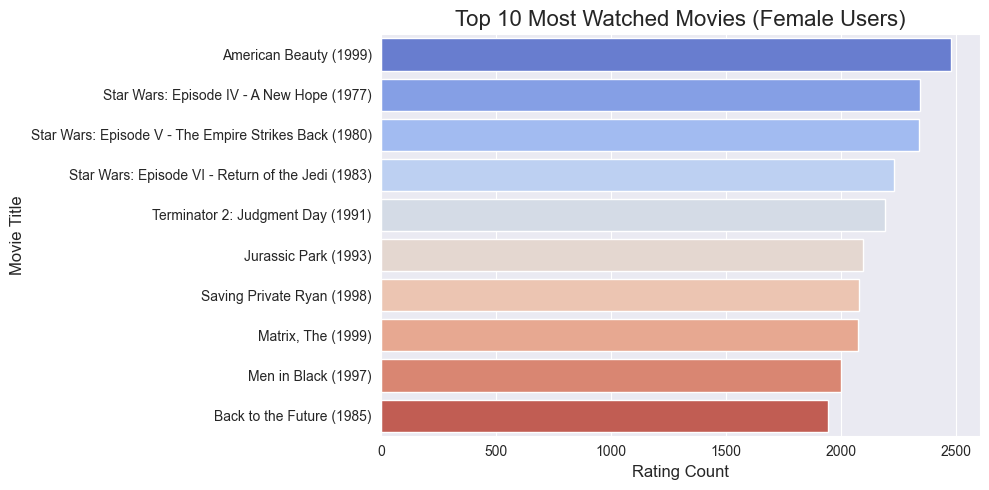

In [150]:
# Step 1: Standardize column names
ratings_df.rename(columns={'UserID': 'user_id', 'MovieID': 'movie_id'}, inplace=True)
users_df.rename(columns={'UserID': 'user_id'}, inplace=True)
movie_df.rename(columns={'MovieID': 'movie_id'}, inplace=True)

# Clean column names in users_df and movie_df
users_df.columns = users_df.columns.str.lower().str.strip()
movie_df.columns = movie_df.columns.str.lower().str.strip()

# Step 2: Merge data
rating_user_df = ratings_df.merge(users_df, on='user_id', how='inner')
rating_user_movie_df = rating_user_df.merge(movie_df, on='movie_id', how='inner')

# Step 3: Define plot function
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(10, 5))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')
    plt.title(title, fontsize=16)
    plt.xlabel('Rating Count', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.tight_layout()
    plt.show()

# Step 4: Group ratings by gender and movie
top_rated_movies_gender_wise = rating_user_movie_df.groupby(['gender', 'movie_id']).size()

# Step 5: Loop through genders and plot top 10
for gender in top_rated_movies_gender_wise.index.get_level_values(0).unique():
    
    # Get top 10 movies rated by this gender
    top_10_gender_rated_movies = top_rated_movies_gender_wise[gender].sort_values(ascending=False).head(10)

    # Merge with movie titles
    top_movies = top_10_gender_rated_movies.reset_index().merge(
        movie_df[['movie_id', 'title']], on='movie_id'
    )

    # Clean gender label
    gender_label = 'Male' if gender == 'm' else 'Female'

    # Plot
    draw_horizontal_movie_bar(
        movie_titles=top_movies['title'],
        ratings_count=top_movies[0],
        title=f'Top 10 Most Watched Movies ({gender_label} Users)'
    )


## Top 10 Most Watched Movies by Age Group
### In this section, we explore the most-watched movies by each age group. This allows us to see which titles are most popular among different age segments of users.

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


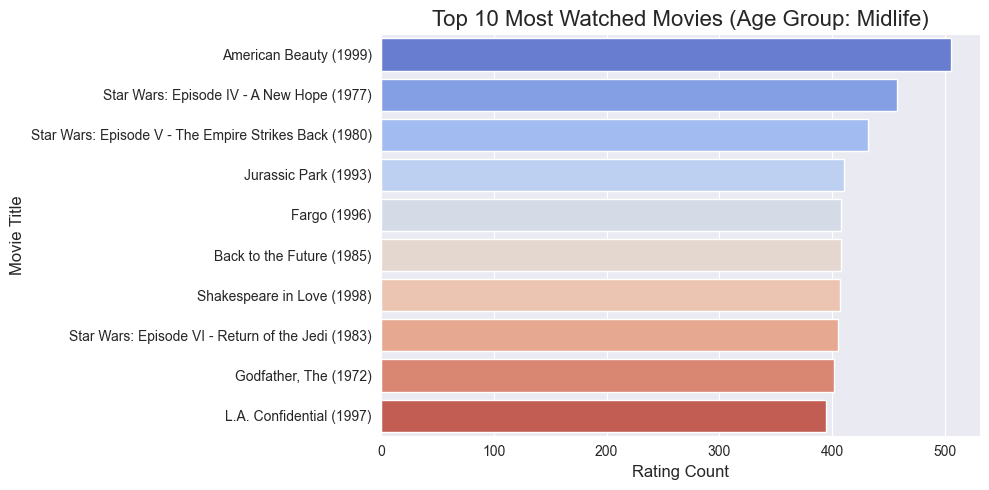

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


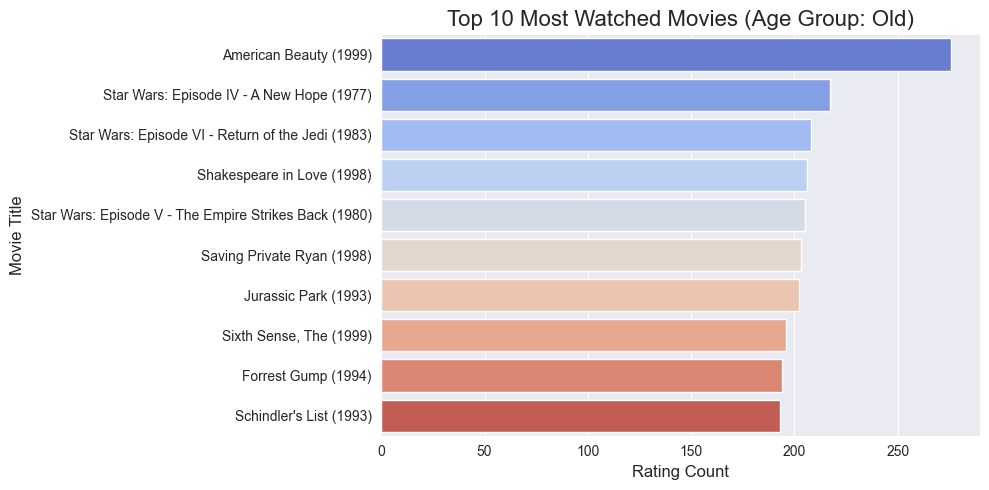

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


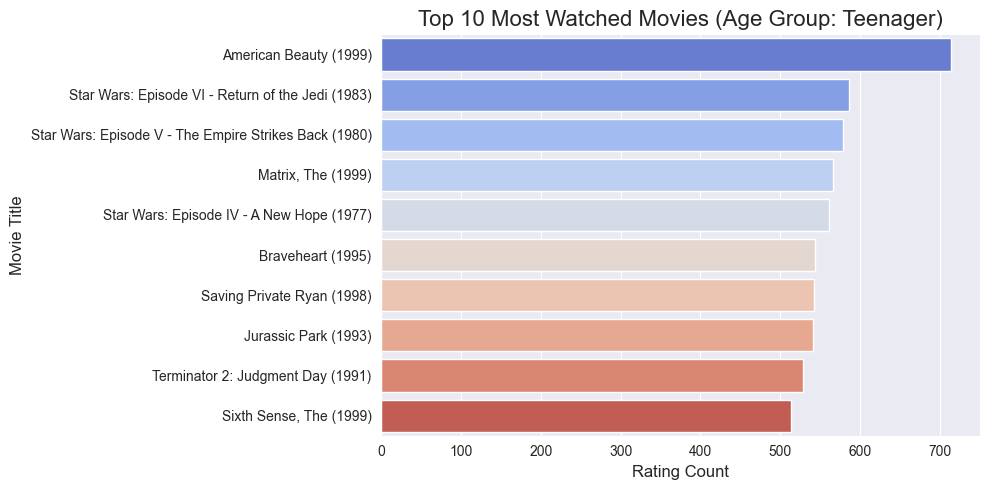

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


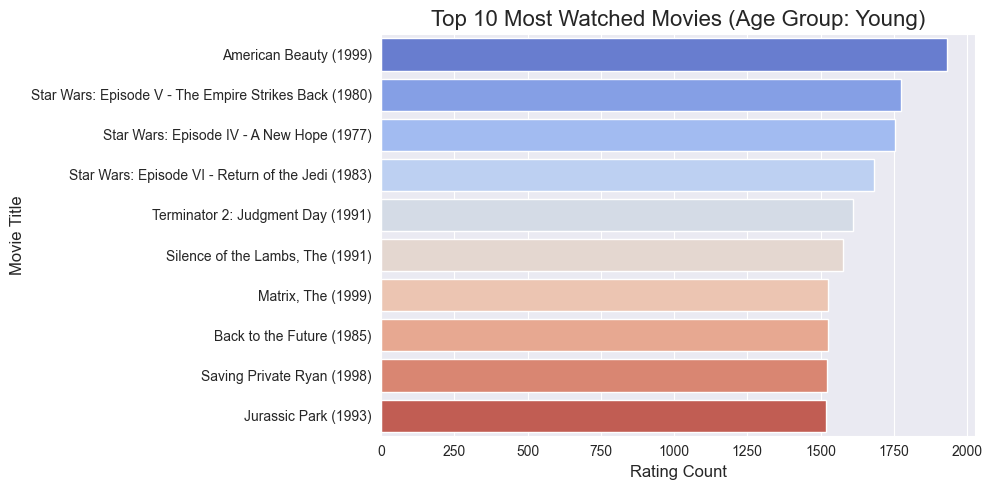

In [151]:
# Step 1: Group ratings by age group and movie
top_rated_movies_age_group_wise = rating_user_movie_df.groupby(['age_group', 'movie_id']).size()

# Step 2: Loop through each age group and visualize top 10 movies
for age_group in top_rated_movies_age_group_wise.index.get_level_values(0).unique():
    
    # Get top 10 movies for this age group
    top_10_age_rated_movies = top_rated_movies_age_group_wise[age_group].sort_values(ascending=False).head(10)

    # Merge with movie_df to get movie titles
    top_movies = top_10_age_rated_movies.reset_index().merge(
        movie_df[['movie_id', 'title']], on='movie_id'
    )

    # Plot the result
    draw_horizontal_movie_bar(
        movie_titles=top_movies['title'],
        ratings_count=top_movies[0],
        title=f'Top 10 Most Watched Movies (Age Group: {age_group})'
    )


## Top 10 Most Loved Movies
### This chart shows the top 10 movies with the highest total rating score, highlighting movies that are not just frequently watched — but also highly appreciated by users.

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


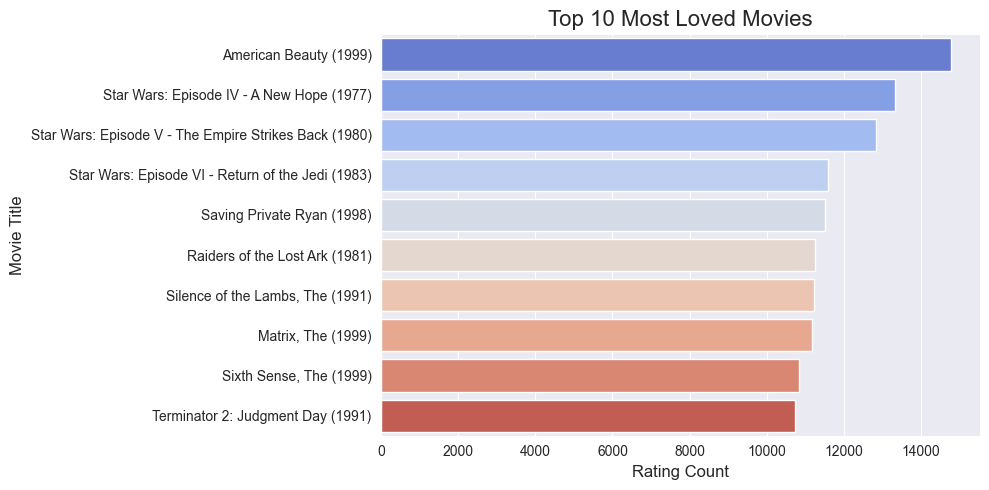

In [152]:
# Step 0: Standardize the rating column
ratings_df.rename(columns={'Rating': 'rating'}, inplace=True)

# Step 1: Get top 10 most loved movies based on total rating score
top_ten_most_loved_movies = ratings_df.groupby('movie_id').sum().rating.sort_values(ascending=False).head(10)

# Step 2: Merge with movie titles
top_movies = top_ten_most_loved_movies.reset_index().merge(
    movie_df[['movie_id', 'title']], on='movie_id'
)

# Step 3: Plot the result
draw_horizontal_movie_bar(
    movie_titles=top_movies['title'],
    ratings_count=top_movies['rating'],
    title='Top 10 Most Loved Movies'
)

## Top 10 Most Loved Movies by Gender
### This section highlights the Top 10 movies that received the highest total ratings from each gender group — giving insight into not just what was watched, but what was loved.

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


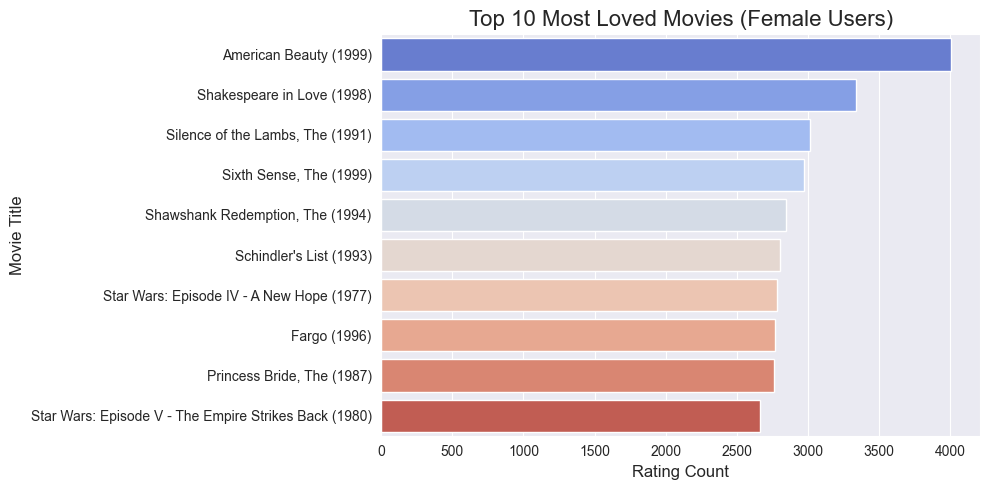

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


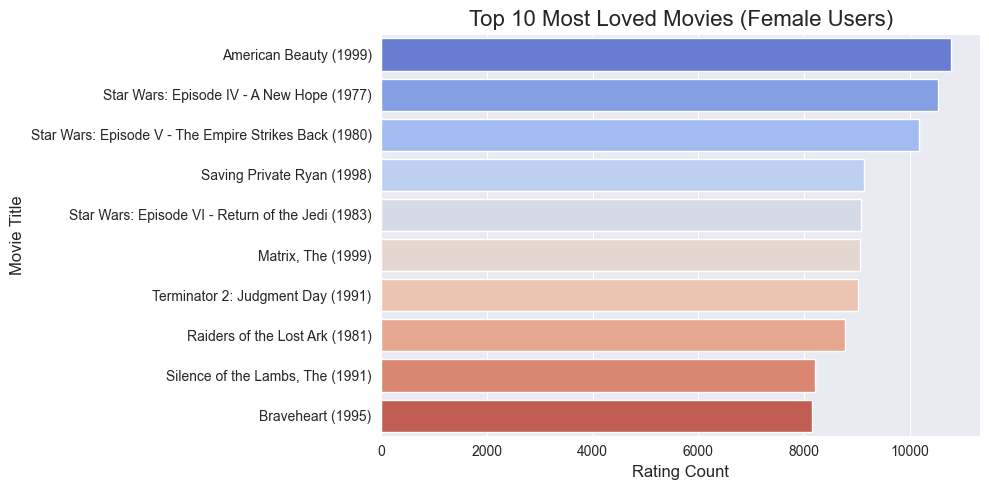

In [153]:
# Step 0: Standardize rating column (if needed)
rating_user_movie_df.rename(columns={'Rating': 'rating'}, inplace=True)

# Step 1: Group by gender and movie_id, summing ratings
most_loved_movies_gender_wise = rating_user_movie_df.groupby(['gender', 'movie_id']).sum().rating

# Step 2: Loop through each gender and get top 10 most loved movies
for gender in most_loved_movies_gender_wise.index.get_level_values(0).unique():
    
    # Top 10 movies with highest total rating for this gender
    top_10_loved = most_loved_movies_gender_wise[gender].sort_values(ascending=False).head(10)

    # Merge with movie_df to get titles
    top_movies = top_10_loved.reset_index().merge(
        movie_df[['movie_id', 'title']], on='movie_id'
    )

    # Gender label cleanup
    gender_label = 'Male' if gender == 'm' else 'Female'

    # Plot
    draw_horizontal_movie_bar(
        movie_titles=top_movies['title'],
        ratings_count=top_movies['rating'],
        title=f'Top 10 Most Loved Movies ({gender_label} Users)'
    )


## Top 10 Most Loved Movies by Age Group
### This section identifies the most loved movies — those with the highest total rating score — for each age group

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


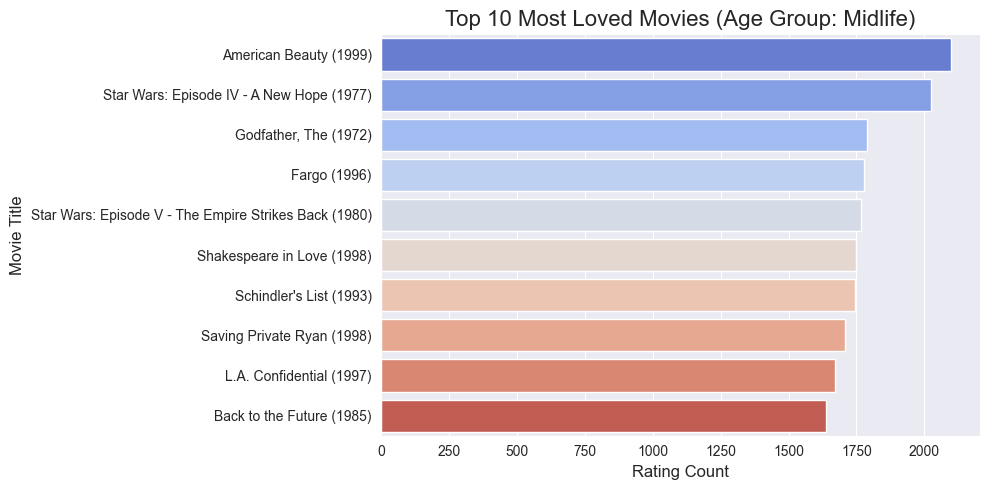

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


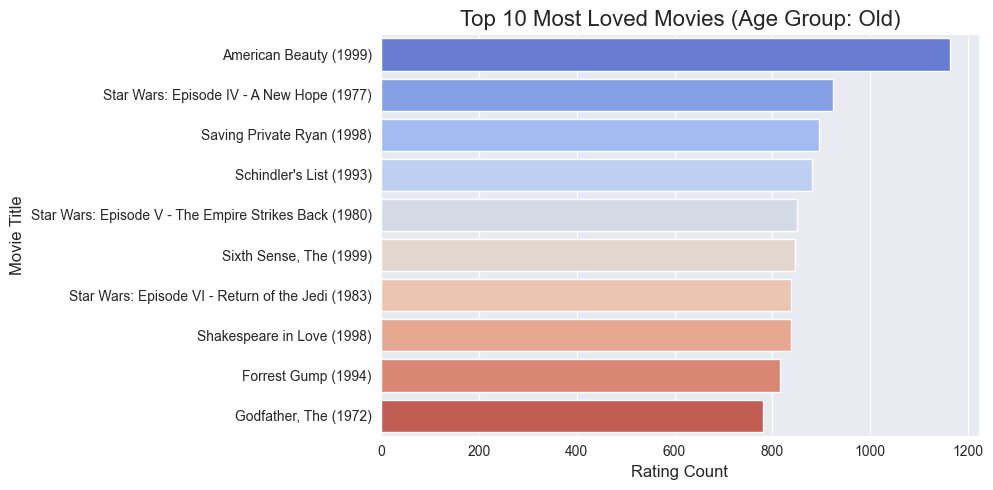

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


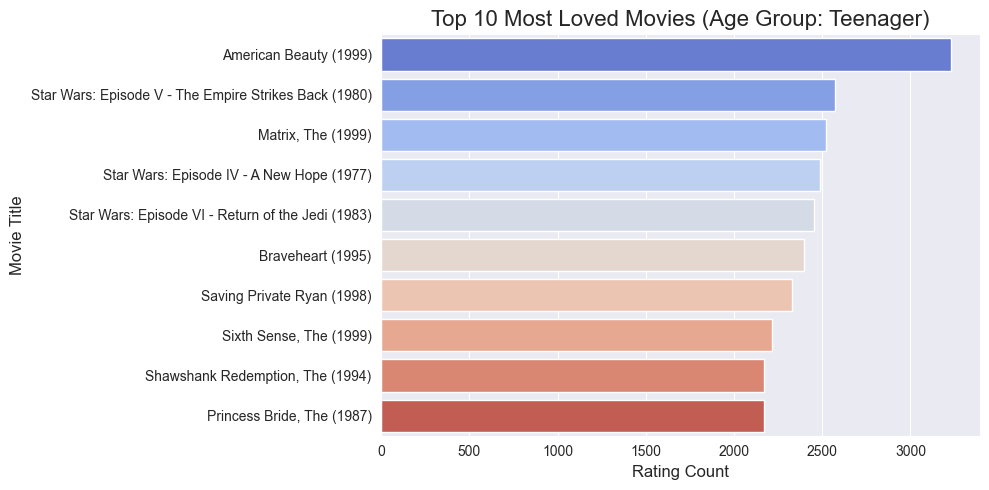

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/1180189743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_titles, x=ratings_count, orient='h', palette='coolwarm')


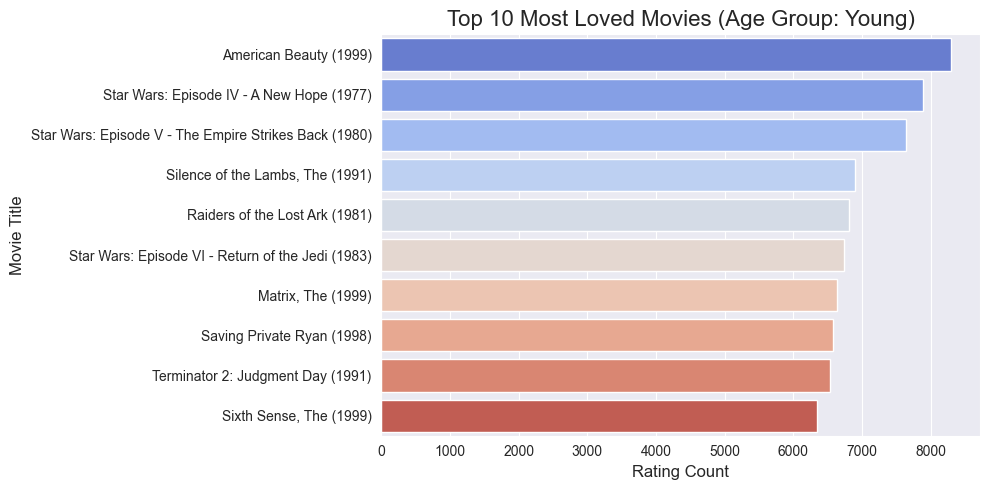

In [154]:
# Step 1: Group by age group and movie_id, summing ratings
most_loved_movies_age_group_wise = rating_user_movie_df.groupby(['age_group', 'movie_id']).sum().rating

# Step 2: Loop through each age group and visualize top 10 loved movies
for age_group in most_loved_movies_age_group_wise.index.get_level_values(0).unique():
    
    # Get top 10 most loved movies for this age group
    top_10_loved = most_loved_movies_age_group_wise[age_group].sort_values(ascending=False).head(10)

    # Merge with movie titles
    top_movies = top_10_loved.reset_index().merge(
        movie_df[['movie_id', 'title']], on='movie_id'
    )

    # Plot the results
    draw_horizontal_movie_bar(
        movie_titles=top_movies['title'],
        ratings_count=top_movies['rating'],
        title=f'Top 10 Most Loved Movies (Age Group: {age_group})'
    )


## WordCloud: Lowest-Rated Movies
### This visualization highlights movies that received very low total rating scores (≤ 10). The lower the rating, the larger the font in the word cloud.



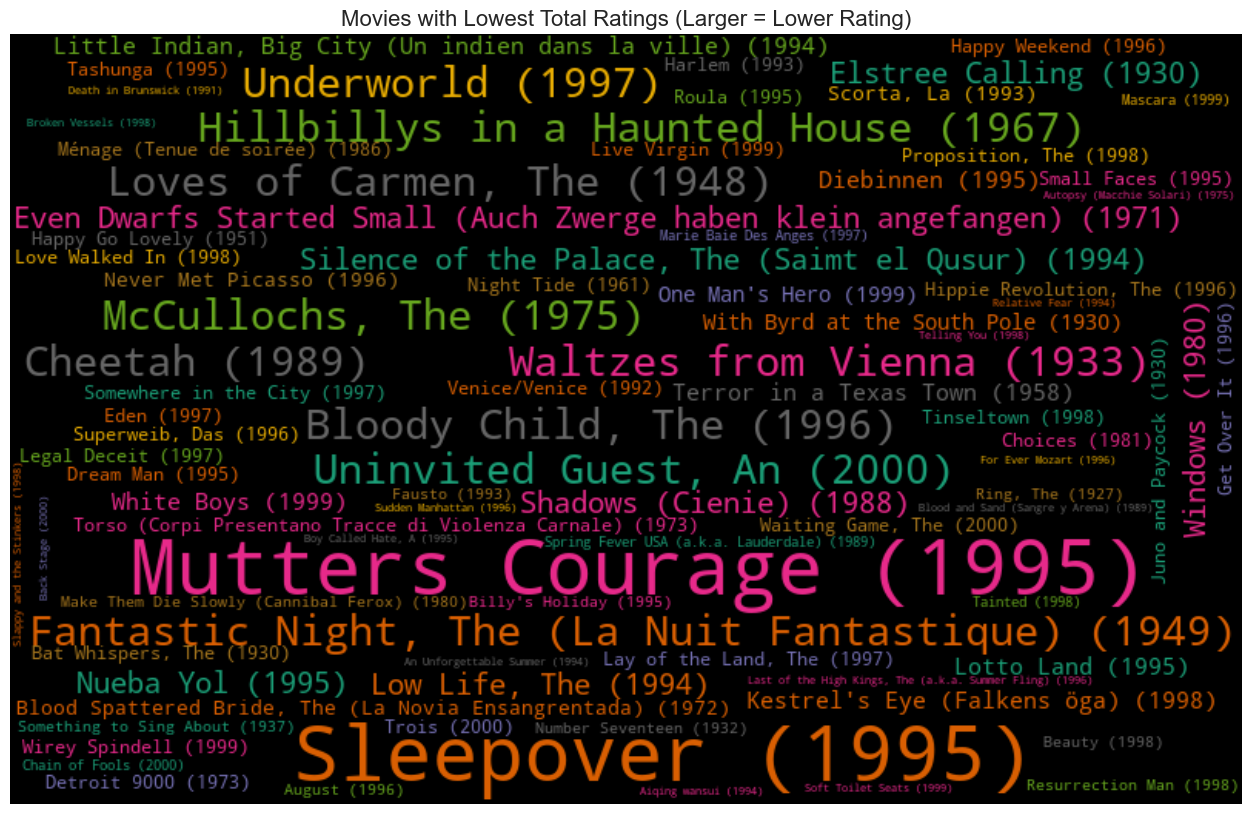

In [155]:
# Step 1: Sum total ratings per movie
rating_user_movie_df.rename(columns={'Rating': 'rating'}, inplace=True)  # if not already lowercase
movies_ratings_sum = rating_user_movie_df.groupby('movie_id').sum().rating.sort_values()

# Step 2: Merge to get movie titles
movies_ratings_sum = movies_ratings_sum.reset_index().merge(
    movie_df[['movie_id', 'title']], on='movie_id'
)

# Step 3: Filter movies with total rating <= 10 and > 0
lowest_rated_movies = movies_ratings_sum[
    (movies_ratings_sum['rating'] > 0) & (movies_ratings_sum['rating'] <= 10)
]

# Step 4: Generate word frequencies for the cloud (inverted so lowest-rated = biggest text)
word_freq = (11 - lowest_rated_movies.set_index('title')['rating']).to_dict()

# Step 5: Generate and display the WordCloud
wordcloud = WordCloud(
    min_font_size=7,
    width=800,
    height=500,
    random_state=21,
    max_font_size=50,
    relative_scaling=0.5,
    colormap='Dark2'
)
wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Movies with Lowest Total Ratings (Larger = Lower Rating)", fontsize=16)
plt.show()


## Cleaning Ratings Data

In [156]:
# Rename columns
ratings_df = ratings_df.rename(columns={
    'user_id': 'user_id',
    'movie_id': 'movie_id',
    'rating': 'Rating',
    'Timestamp': 'Date'
})

# Convert 'Date' column from UNIX timestamp to datetime
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'], unit='s').dt.normalize()

# Create YearMonth feature
ratings_df['YearMonth'] = ratings_df['Date'].dt.to_period('M').astype(str)

# Sampling and saving final DataFrames

## Unique Values in the Ratings Dataset

In [157]:
ratings_df.nunique()

user_id      6040
movie_id     3706
Rating          5
Date         1040
YearMonth      35
dtype: int64

## Step 1: Stratified Sampling (10% by Rating)


In [158]:
# Step 1: Your original rating-based sampling
sample_frac = 0.10
sampled_df = ratings_df.groupby('Rating', group_keys=False).apply(
    lambda x: x.sample(frac=sample_frac, random_state=42)
).reset_index(drop=True)

# Step 2: Now take 10% of the users from this sampled data
unique_users = sampled_df['user_id'].unique()
sampled_users = pd.Series(unique_users).sample(frac=0.10, random_state=42)

# Filter the dataframe to only include those users
final_sampled_df = sampled_df[sampled_df['user_id'].isin(sampled_users)]
final_sampled_df

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_12588/485929575.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = ratings_df.groupby('Rating', group_keys=False).apply(


,user_id,movie_id,Rating,Date,YearMonth
8,5621,358,1,2000-05-23,2000-05
14,5112,2450,1,2000-06-30,2000-06
15,203,147,1,2000-12-16,2000-12
17,4387,1007,1,2000-08-05,2000-08
23,5980,2414,1,2000-04-28,2000-04
...,...,...,...,...,...
99962,1041,2186,5,2000-11-23,2000-11
99978,3842,1963,5,2000-08-10,2000-08
99994,1324,1213,5,2000-11-21,2000-11
99995,3580,353,5,2000-08-19,2000-08


## Step 2: Define Comparison Function for Bar Charts


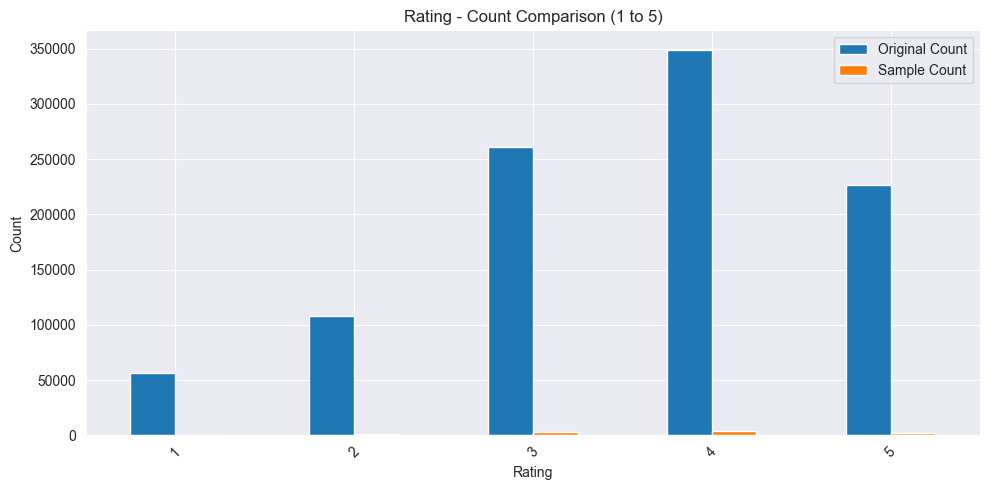

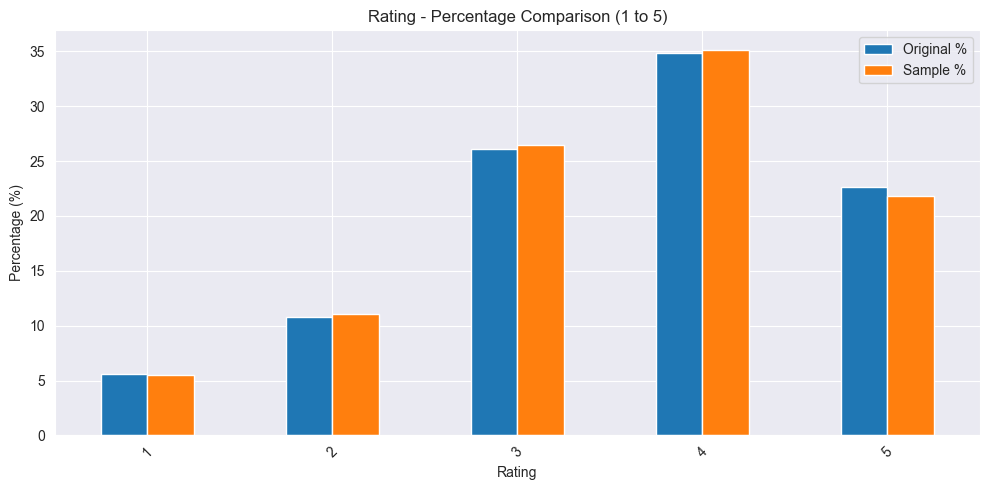

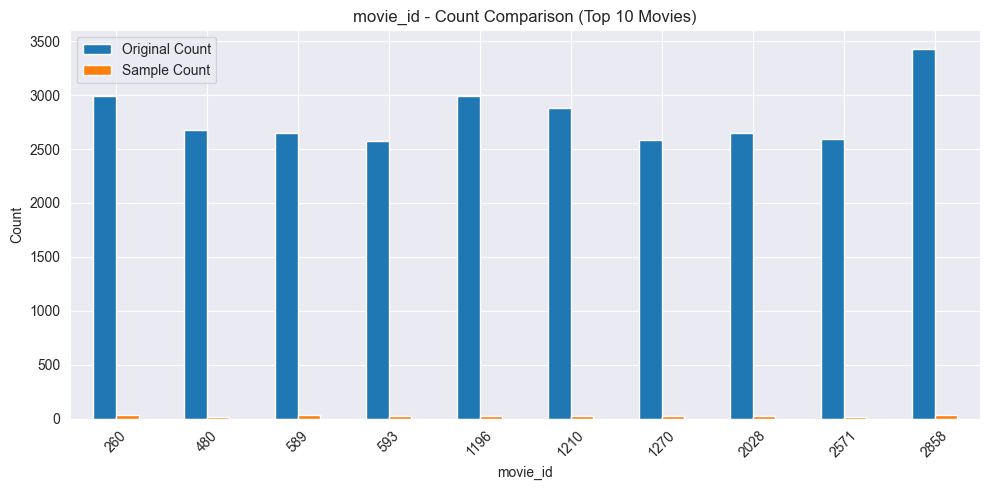

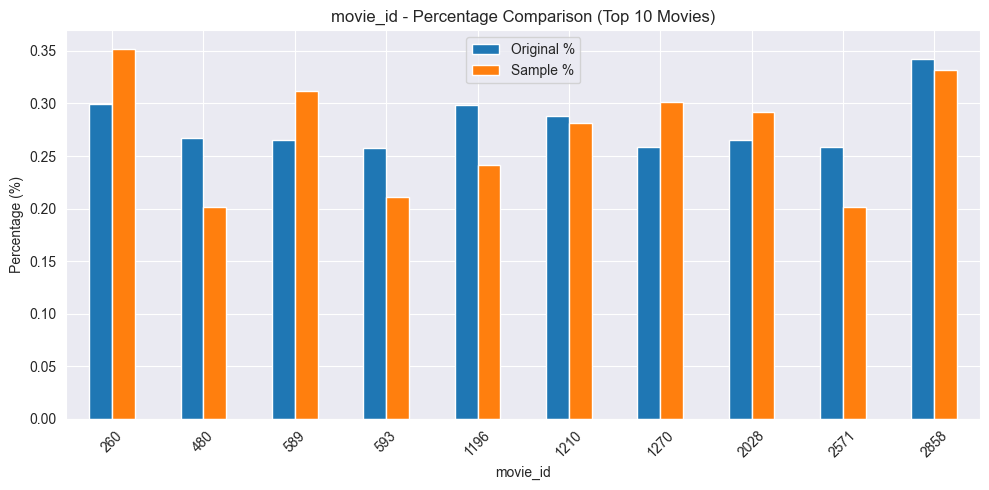

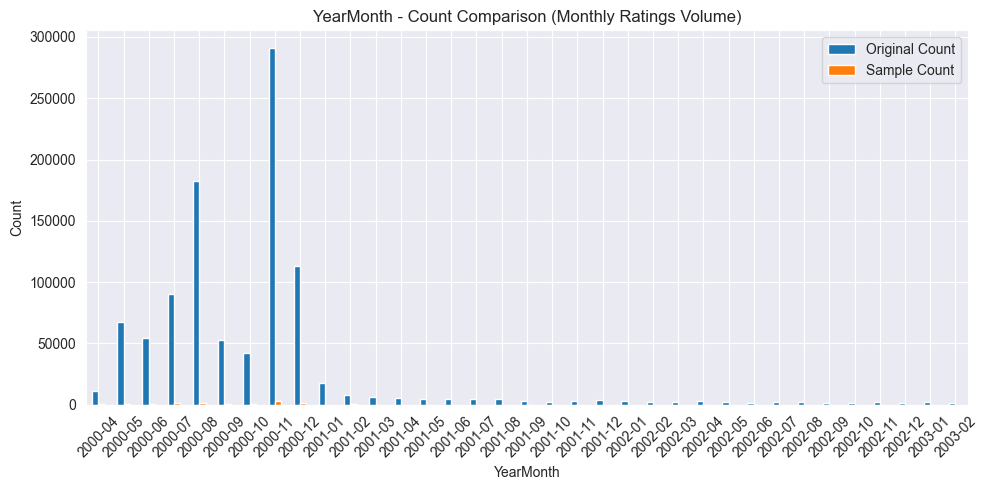

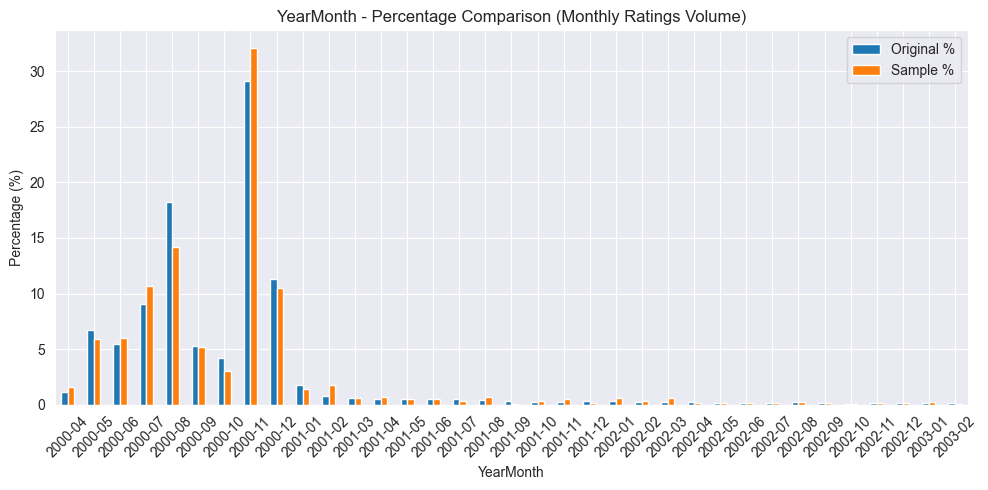

In [159]:
def compare_distributions(original_df, final_sampled_df, column, top_n=None, title_suffix=""):
    orig_counts = original_df[column].value_counts()
    samp_counts = final_sampled_df[column].value_counts()

    orig_pct = orig_counts / len(original_df) * 100
    samp_pct = samp_counts / len(final_sampled_df) * 100

    if top_n:
        top_items = orig_counts.head(top_n).index
        top_items = top_items.intersection(samp_counts.index)
        orig_counts = orig_counts.loc[top_items]
        samp_counts = samp_counts.loc[top_items]
        orig_pct = orig_pct.loc[top_items]
        samp_pct = samp_pct.loc[top_items]

    df_compare = pd.DataFrame({
        'Original Count': orig_counts,
        'Sample Count': samp_counts,
        'Original %': orig_pct,
        'Sample %': samp_pct
    }).fillna(0).sort_index()

    # Count comparison
    ax = df_compare[['Original Count', 'Sample Count']].plot(
        kind='bar', figsize=(10, 5), title=f"{column} - Count Comparison {title_suffix}", grid=True
    )
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Percentage comparison
    ax = df_compare[['Original %', 'Sample %']].plot(
        kind='bar', figsize=(10, 5), title=f"{column} - Percentage Comparison {title_suffix}", grid=True
    )
    ax.set_ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage (replace with your actual DataFrames)
compare_distributions(ratings_df, final_sampled_df, 'Rating', title_suffix='(1 to 5)')
compare_distributions(ratings_df, final_sampled_df, 'movie_id', top_n=10, title_suffix='(Top 10 Movies)')
compare_distributions(ratings_df, final_sampled_df, 'YearMonth', title_suffix='(Monthly Ratings Volume)')


## Step 3: Compare Distributions (Rating, User, Movie, Month)

In [160]:
def compare_distributions(orig_df, samp_df, col, top_n=None, title_suffix=''):
    import matplotlib.pyplot as plt
    import pandas as pd

    orig_counts = orig_df[col].value_counts()
    samp_counts = samp_df[col].value_counts()

    orig_pct = orig_counts / orig_counts.sum()
    samp_pct = samp_counts / samp_counts.sum()

    if top_n:
        top_items = orig_counts.head(top_n).index

        # Safely handle missing items in sampled data
        common_items = top_items.intersection(samp_counts.index)
        if len(common_items) < len(top_items):
            missing = top_items.difference(samp_counts.index)
            print(f"[Warning] Missing in sample for '{col}': {list(missing)}")

        orig_counts = orig_counts.loc[common_items]
        samp_counts = samp_counts.loc[common_items]
        orig_pct = orig_pct.loc[common_items]
        samp_pct = samp_pct.loc[common_items]

    df_plot = pd.DataFrame({
        'Original %': orig_pct,
        'Sampled %': samp_pct
    })

    # Same bar plot style
    df_plot.plot(kind='bar', figsize=(12, 6), title=f'Distribution of {col} {title_suffix}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## Step 4: Line Plot – Monthly Ratings Over Time

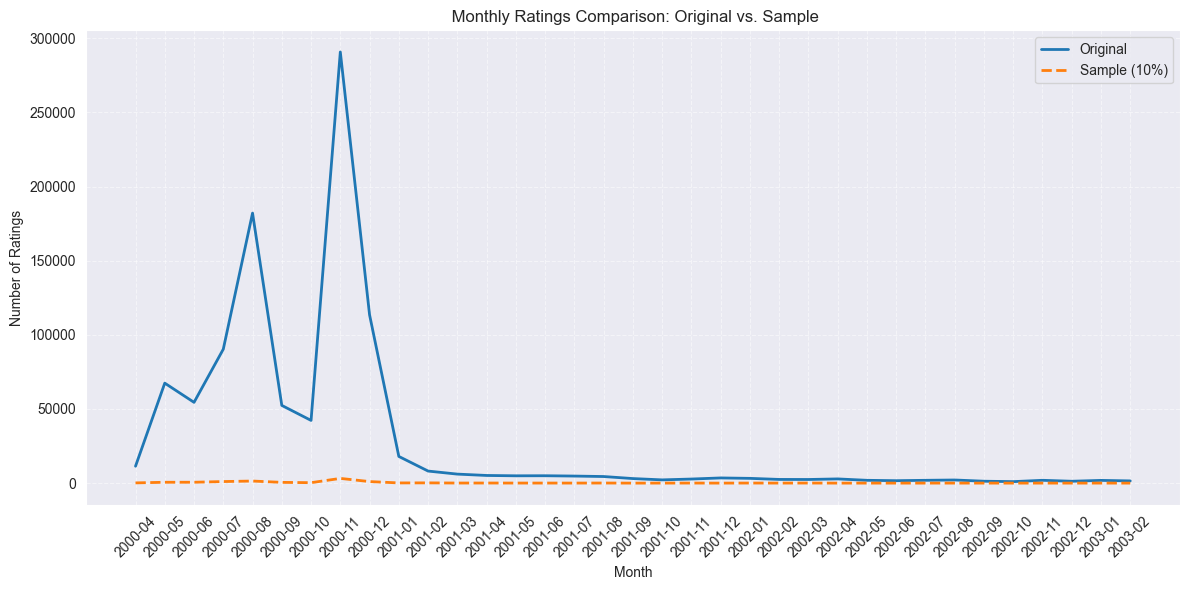

In [161]:
monthly_counts_full = ratings_df['YearMonth'].value_counts().sort_index()
monthly_counts_sample = final_sampled_df['YearMonth'].value_counts().sort_index()

df_monthly = pd.DataFrame({
    'Original': monthly_counts_full,
    'Sample': monthly_counts_sample
}).fillna(0)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Original'], label='Original', linewidth=2)
plt.plot(df_monthly.index, df_monthly['Sample'], label='Sample (10%)', linewidth=2, linestyle='--')
plt.title(' Monthly Ratings Comparison: Original vs. Sample')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Step 5: Area Chart – Monthly Rating Composition by Score

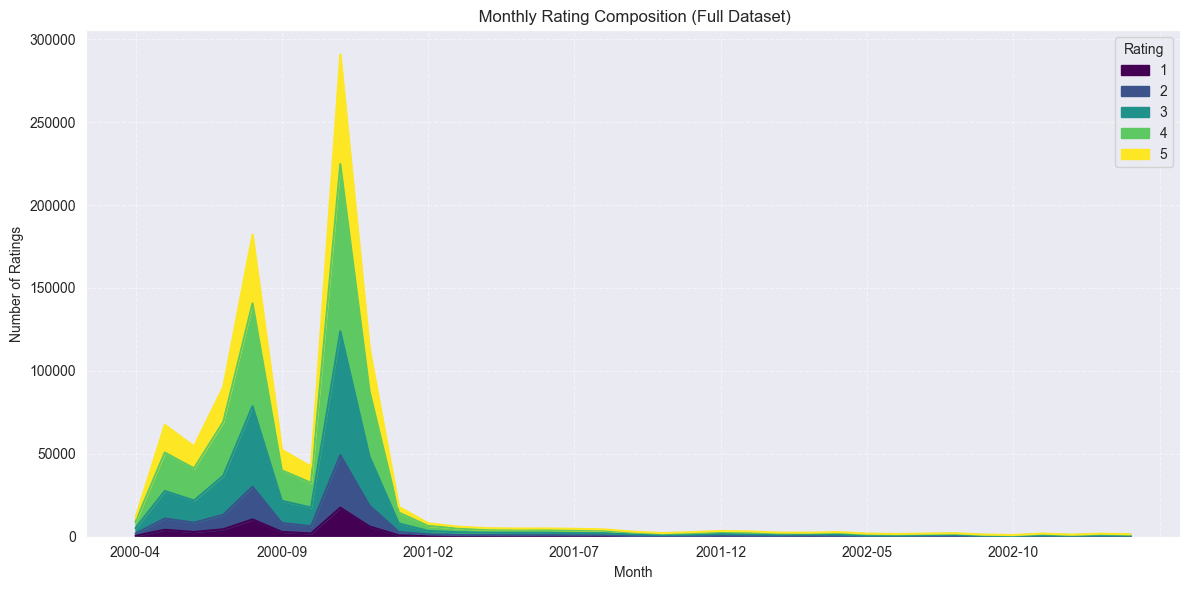

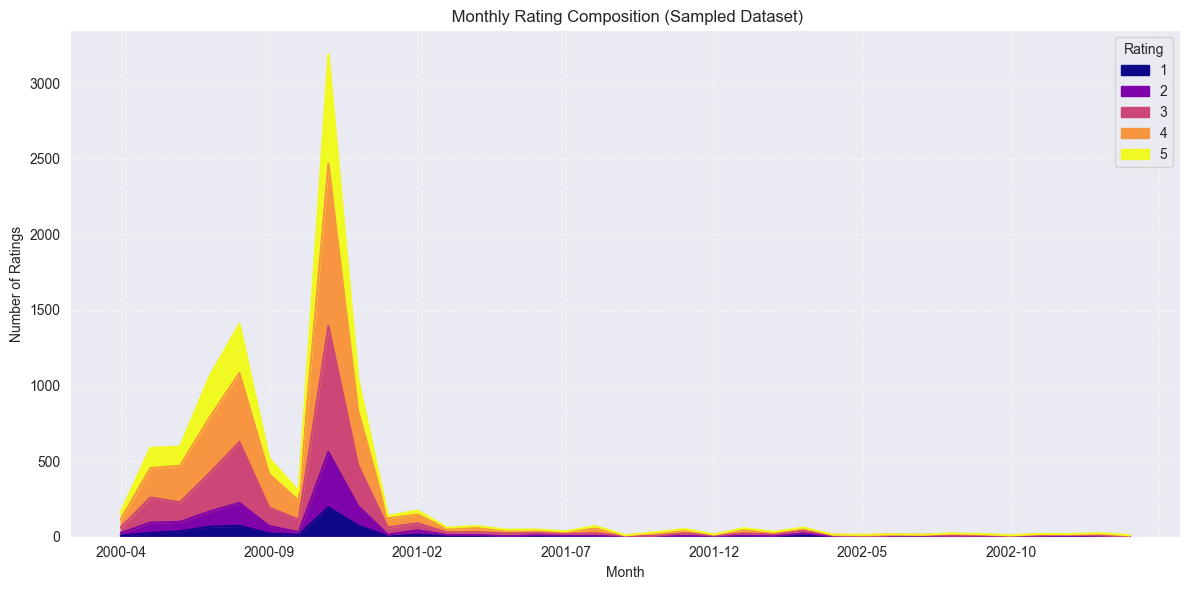

In [162]:
# Group by month and rating
monthly_rating_full = ratings_df.groupby([ratings_df['Date'].dt.to_period('M'), 'Rating']).size().unstack(fill_value=0)
monthly_rating_sample = final_sampled_df.groupby([sampled_df['Date'].dt.to_period('M'), 'Rating']).size().unstack(fill_value=0)

monthly_rating_full.index = monthly_rating_full.index.astype(str)
monthly_rating_sample.index = monthly_rating_sample.index.astype(str)

# Full dataset area chart
monthly_rating_full.plot.area(
    figsize=(12, 6),
    title=' Monthly Rating Composition (Full Dataset)',
    colormap='viridis'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Sampled dataset area chart
monthly_rating_sample.plot.area(
    figsize=(12, 6),
    title=' Monthly Rating Composition (Sampled Dataset)',
    colormap='plasma'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Step 6: Unique Value Comparison: Original vs Sampled Dataset

In [163]:
def compare_and_plot_uniques(original_df, sampled_df, columns):
    summary = []

    for col in columns:
        orig_unique = original_df[col].nunique()
        samp_unique = sampled_df[col].nunique()
        pct_diff = ((samp_unique - orig_unique) / orig_unique) * 100

        summary.append({
            'Column': col,
            'Original Unique': orig_unique,
            'Sampled Unique': samp_unique,
            'Difference': samp_unique - orig_unique,
            '% Difference': round(pct_diff, 2)
        })

    df_summary = pd.DataFrame(summary)

    return df_summary

columns_to_check = ['user_id', 'movie_id', 'Rating', 'Date', 'YearMonth']
compare_and_plot_uniques(ratings_df, final_sampled_df, columns_to_check)


,Column,Original Unique,Sampled Unique,Difference,% Difference
0,user_id,6040,597,-5443,-90.12
1,movie_id,3706,2254,-1452,-39.18
2,Rating,5,5,0,0.00
3,Date,1040,465,-575,-55.29
4,YearMonth,35,35,0,0.00


In [164]:
final_sampled_df.to_parquet("./dataset_samples/df_movie_lens.parquet", index=False)

## Step 7: save user and movie dataframes

In [165]:
movie_df.to_parquet("./dataset_samples/df_movie_lens_movies.parquet", index=False)
users_df.to_parquet("./dataset_samples/df_movie_lens_users.parquet", index=False)